In [766]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

In [767]:
sns.set_theme()
# params
kon = 1e5
koff = 1e-4
Target_cell_number = 5e3
E_T_ratios = [1.25, 2.5, 5, 10, 20]
rtot = 1e5
rtot_f = 2.2e5
qon = 6.5e3
qoff = 4.7e-3
k1off = koff
k2off = 2*koff
k3off = qoff
k4off = qoff
k5off = qoff
k6off = koff
k7off = 2*koff
gamma2 = k2off/k1off
gamma3 = k3off/k1off
gamma4 = k4off/k1off
gamma5 = k5off/k1off
gamma6 = k6off/k1off
gamma7 = k7off/k1off


In [768]:
def NK_cell(t, z, A_0, Atot_system, E_T_ratio):
    q = A_0*qon
    sigma = q/koff
    epsilon = qoff/koff
    Atot_effector = Atot_system/E_T_ratio
    eta = Atot_effector/rtot_f

    return sigma*(eta-z)*(1-z) - epsilon*z


In [769]:
def single_cell(t, z, delta, A_0):

    Ainit = A_0
    k = Ainit*kon
    k1 = 2*k
    alpha1 = k1/k1off
    Atot = 1e16*Ainit/Target_cell_number
    beta = Atot/rtot

    dA1 = alpha1*(1-z[0]-2*z[1])*(beta-z[0]-z[1]) - z[0] - delta*alpha1*(1-z[0]-2*z[1])*z[0] + 2*z[1]
    dA2 = delta*alpha1*(1-z[0]-2*z[1])*z[0] - 2*z[1]

    return [dA1, dA2]


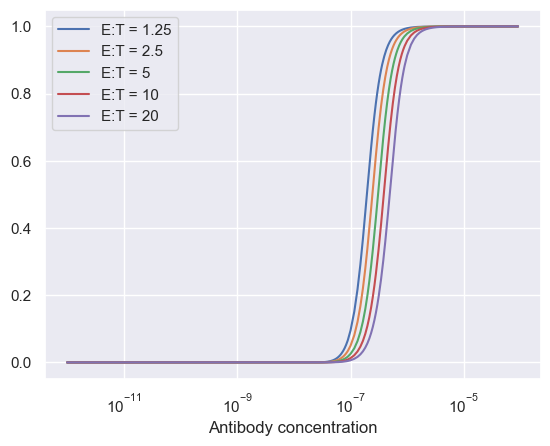

In [770]:
vals = np.linspace(1, 9, 50)
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = []
t_end1 = 1
t1 = np.geomspace(1e-10, t_end1, 100)
t_span1 = [0, t_end1]
tend = 100
t = np.geomspace(1e-10, tend, 100)
t_span = [1e-10, tend]

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

solutions = []

delta = 1

for val in E_T_ratios:

    A1fs = np.zeros_like(A0s)

    for i in range(len(A0s)):

        A_0 = A0s[i]
        z = solve_ivp(single_cell, t_span, [0, 0], method='Radau', args=(delta, A_0), t_eval=t)
        Atot = 1e16*A_0/Target_cell_number
        beta = Atot/rtot

        A1 = z.y[0]
        A2 = z.y[1]
        A0 = beta - A1  - A2
        A0_IC = A0[-1]*Atot

        z1 = solve_ivp(NK_cell, t_span1, [0], method='Radau', args=(A_0, A0_IC, val), t_eval=t1)

        A1f = z1.y[0]
        A1fs[i] = A1f[-1]

    solutions.append(A1fs)

for i in range(len(solutions)):

    plt.plot(A0s, solutions[i], label='E:T = ' + str(E_T_ratios[i]))
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Antibody concentration')
plt.show()

In [771]:
def two_cells(t, z, phi, delta2, delta4, delta7, A_0, A10_0, A20_0, A01_0):

    Ainit = A_0
    k = Ainit*kon
    q = qon*Ainit
    delta5 = delta4*delta7/delta2
    delta6 = delta4
    k1 = 2*k
    k2 = delta2*k
    k3 = q
    k4 = delta4*q
    k5 = delta5*q
    k6 = 2*delta6*k
    k7 = delta7*k

    alpha1 = k1/k1off
    alpha2 = k2/k1off
    alpha3 = k3/k1off
    alpha4 = k4/k1off
    alpha5 = k5/k1off
    alpha6 = k6/k1off
    alpha7 = k7/k1off

    beta_synapse = 1e1*Ainit
    beta_t = beta_synapse + A10_0 + A20_0 + (A01_0/phi)
    beta_f = phi*beta_t

    A00 = (1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4] + (1/phi)*z[2]))
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [772]:
def single_cell_stst(delta, A_0):

    z0 = [0, 0]

    # solve single cell model to obtain equilibrium values
    # to use as ics for A10 and A20 in two cell model
    z = solve_ivp(single_cell, t_span, z0, method='Radau', args=(delta, A_0), t_eval=t)
    A1 = z.y[0]
    A2 = z.y[1]
    A1_stst = A1[-1]
    A2_stst = A2[-1]
    
    return [A1_stst, A2_stst]

def NK_cell_IC(A_0, A1_stst, A2_stst, E_T_ratio):

    Atot = 1e16*A_0/Target_cell_number
    beta = Atot/rtot

    A0 = beta - A1_stst - A2_stst
    A0_IC = A0*Atot

    z1 = solve_ivp(NK_cell, t_span1, [0], method='Radau', args=(A_0, A0_IC, E_T_ratio), t_eval=t1)

    A1f = z1.y[0]

    return A1f[-1]
    

In [773]:
A_0 = 1e-7
delta2 = 1
delta4 = 1
delta7 = 1
phi = 0.5
E_T_ratio = 10

ICS = single_cell_stst(delta2, A_0)
A10_0 = ICS[0]
A20_0 = ICS[1]
A01_0 = NK_cell_IC(A_0, A10_0, A20_0, E_T_ratio)
beta_t = 1e1*A_0 + A10_0 + A20_0 + (A01_0/phi)
beta_f = beta_t*phi
z0 = [A10_0, A20_0, A01_0, 0, 0]
z = solve_ivp(two_cells, t_span, z0, method='Radau', t_eval=t, args=(phi, delta2, delta4, delta7, A_0, A10_0, A20_0, A01_0))
Atot = 1e16*A_0/Target_cell_number
A00_vals = (1 - (1/beta_t)*(z.y[0] + z.y[1] + z.y[3] + z.y[4] + (1/phi)*z.y[2]))
rt_vals = 1-(1- z.y[0] - z.y[3] - 2*(z.y[1] + z.y[4]))
rf_vals = (1-(1 - z.y[2] - phi*(z.y[3] + z.y[4])))

A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]

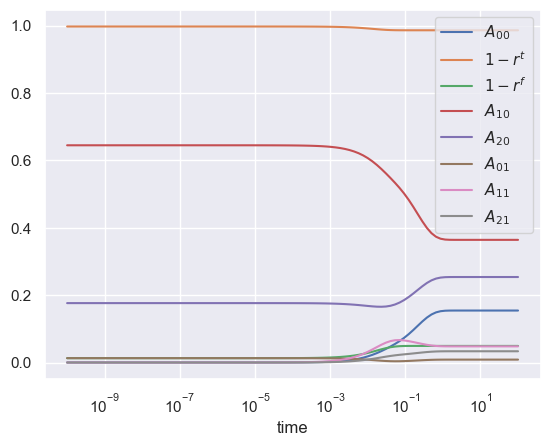

In [774]:
plt.plot(t, A00_vals, label = r'$A_{00}$')
plt.plot(t, rt_vals, label = r'$1 - r^t$')
plt.plot(t, rf_vals, label = r'$1 - r^f$')
plt.plot(t, A10, label = r'$A_{10}$')
plt.plot(t, A20, label = r'$A_{20}$')
plt.plot(t, A01, label = r'$A_{01}$')
plt.plot(t, A11, label = r'$A_{11}$')
plt.plot(t, A21, label = r'$A_{21}$')
plt.xlabel('time')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [775]:
vals = np.linspace(1, 9, 50)
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = []

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

delta2 = 1
delta4 = 1
delta7 = 1
phi = 0.5
E_T_ratio = 1

A10_stst = np.zeros_like(A0s)
A20_stst = np.zeros_like(A0s)
A01_stst = np.zeros_like(A0s)
A11_stst = np.zeros_like(A0s)
A21_stst = np.zeros_like(A0s)
A00_stst = np.zeros_like(A0s)
fc_num_per = np.zeros_like(A0s)
fc_num = np.zeros_like(A0s)

for i in range(len(A0s)):
    A0 = A0s[i]
    ICS = single_cell_stst(delta2, A0)
    A10_0 = ICS[0]
    A20_0 = ICS[1]
    A01_0 = NK_cell_IC(A0, A10_0, A20_0, E_T_ratio)
    beta_t = 1e1*A0 + A10_0 + A20_0 + (A01_0/phi)
    beta_f = beta_t*phi
    z0 = [A10_0, A20_0, A01_0, 0, 0]
    z = solve_ivp(two_cells, t_span, z0, method='Radau', t_eval=t, args=(phi, delta2, delta4, delta7, A0, A10_0, A20_0, A01_0))

    A20 = z.y[1]
    A21 = z.y[4]
    A10 = z.y[0]
    A11 = z.y[3]
    A01 = z.y[2]
    A00 = (1 - (1/beta_t)*(z.y[0] + z.y[1] + z.y[3] + z.y[4] + (1/phi)*z.y[2]))

    A10_stst[i] = A10[-1]
    A20_stst[i] = A20[-1]
    A01_stst[i] = A01[-1]
    A11_stst[i] = A11[-1]
    A21_stst[i] = A21[-1]
    A00_stst[i] = A00[-1]
    fc_num_per[i] = (A21[-1] + A11[-1])/(2*(A21[-1] + A21[-1]) + A10[-1] + A11[-1] + (1 - A10[-1] - A11[-1] - 2*(A20[-1] + A21[-1])))
    fc_num[i] = A21[-1] + A11[-1]

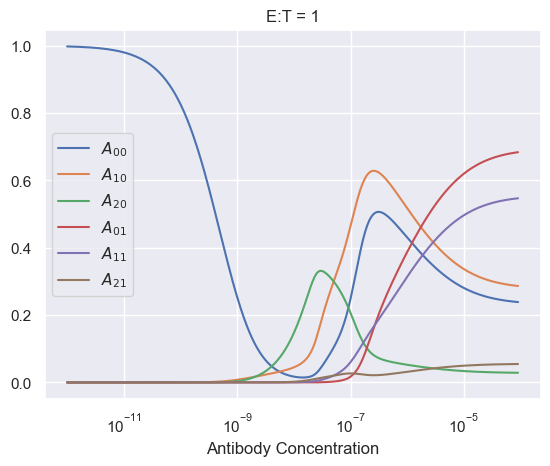

In [776]:
plt.plot(A0s, A00_stst, label = r'$A_{00}$')
plt.plot(A0s, A10_stst, label = r'$A_{10}$')
plt.plot(A0s, A20_stst, label = r'$A_{20}$')
plt.plot(A0s, A01_stst, label = r'$A_{01}$')
plt.plot(A0s, A11_stst, label = r'$A_{11}$')
plt.plot(A0s, A21_stst, label = r'$A_{21}$')
plt.xlabel('Antibody Concentration')
plt.xscale('log')
plt.legend(loc='best')
plt.title('E:T = 1')
plt.show()

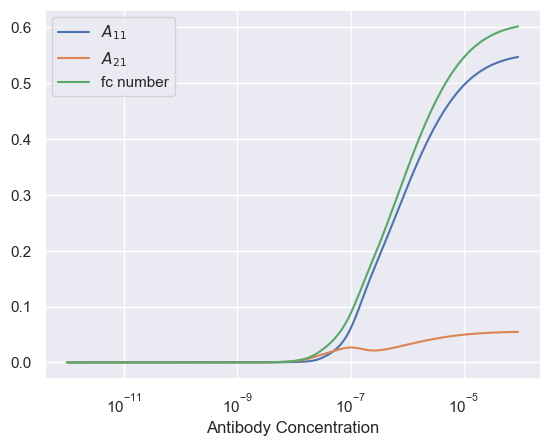

In [777]:
plt.plot(A0s, A11_stst, label = r'$A_{11}$')
plt.plot(A0s, A21_stst, label = r'$A_{21}$')
#plt.plot(A0s, fc_num_per, label='fc number per receptor')
plt.plot(A0s, fc_num, label='fc number')
plt.xlabel('Antibody Concentration')
plt.xscale('log')
plt.legend(loc='best')
plt.show()